# Distance computing between mesh/pixels and stations 

## Import required libraries

In [1]:
import numpy as np    
import pandas as pd    
import netCDF4 as nc    
from netCDF4 import Dataset    
import datetime as dt   
import calendar as cld  
import xarray as xr
from os import listdir 
import os
import mpu   
import matplotlib.pyplot as plt

## For parallelisation 

In [2]:
from dask.distributed import Client
client = Client(n_workers=16, threads_per_worker=2, memory_limit='32GB')
client

/home/hchaabani/anaconda3/envs/first_part/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34597 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34597/status,
Dashboard: http://127.0.0.1:34597/status,Workers: 16
Total threads: 32,Total memory: 476.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41781,Workers: 16
Dashboard: http://127.0.0.1:34597/status,Total threads: 32
Started: Just now,Total memory: 476.84 GiB
Comm: tcp://127.0.0.1:38937,Total threads: 2
Dashboard: http://127.0.0.1:38465/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:32779,


## Set variables

In [13]:
threshold = '0' 

path_raw_data_cmip6 = '/home/hchaabani/Data/Snow/snc/cmip6/raw_data'
path_cmip6 = '/home/hchaabani/Data/Snow/snc/cmip6/modified_data/monthly/monthly_values_plus_alt/threshold_'+threshold
path_era5 = '/home/hchaabani/Data/Snow/snc/Reanalysis/ERA5/modified_data/monthly/monthly_values_plus_alt/threshold_'+threshold
path_era5_land = '/home/hchaabani/Data/Snow/snc/Reanalysis/ERA-LAND/modified_data/monthly/monthly_values_plus_alt/threshold_'+threshold 
path_esa_gf = '/home/hchaabani/Data/Snow/snc/Satellite/ESA_CCI/modified_data/monthly/monthly_values_plus_alt/threshold_'+threshold
path_sim_35km = '/home/hchaabani/Data/Snow/snc/SIM_35km/Modified_data/monthly/monthly_values_plus_alt/threshold_'+threshold


cmip6_labels = os.listdir(path_raw_data_cmip6)
products_labels = ['esa_gf','era5_land','era5', 
                   'SIM_35km']+cmip6_labels

# Stations names acronyms
stations_labels = [ 'IFR', 'MID', 'TIC', 'MGN', 'TIZ', 'OUK']

stations_coors = {'IFR':(-5.16, 33.5, 1663),'MID':(-4.74, 32.67, 1507), 'TIC':(-6.30, 31.53, 3260), 
                   'MGN':(-6.45 ,31.50, 3850),'TIZ':(-6.29, 31.56, 2960),'OUK':(-7.86, 31.20,3620)} 

dic_data = {prod:'data' for prod in products_labels}   

period = ('2000-01-01','2000-12-31')  
stats_dic = {key:'data' for key in stations_labels} 


distances = pd.DataFrame(columns=products_labels)
elevations_diff = pd.DataFrame(columns=products_labels)

distances['station'] = stations_labels
distances = distances.set_index('station')

elevations_diff['station'] = stations_labels
elevations_diff = elevations_diff.set_index('station')

## Import data

In [15]:
for model in cmip6_labels:
    dic_data[model] = xr.open_dataset(path_cmip6+'/snc_monthly_'+model+'_plus_alt.nc').load(time=period)
    
dic_data['era5'] = xr.open_dataset(path_era5+'/snc_monthly_era5_plus_alt.nc').load(time=period)
dic_data['era5_land'] = xr.open_dataset(path_era5_land+'/snc_monthly_era5_land_plus_alt.nc').load(time=period)
dic_data['SIM_35km'] = xr.open_dataset(path_sim_35km+'/snc_monthly_SIM_35km_plus_alt.nc').load(time=period)
dic_data['esa_gf'] = xr.open_dataset(path_esa_gf+'/snc_monthly_esa_gf_plus_alt.nc').load(time=period)

In [16]:
for key in stations_labels:     
    stats_dic[key] = {key:'data' for key in list(dic_data.keys())}    

In [17]:
for stat in stations_labels:                                                  
    for key in list(dic_data.keys()):                 
        stats_dic[stat][key] = dic_data[key].sel(lat=stations_coors[stat][1],lon=stations_coors[stat][0], method='nearest').load()

In [18]:
for stat in stations_labels:
    for prod in products_labels:
        lat_prod = stats_dic[stat][prod].lat.values
        lon_prod = stats_dic[stat][prod].lon.values
         
        lat_stat = stations_coors[stat][1]
        lon_stat = stations_coors[stat][0]
        
        distances[prod][stat] = mpu.haversine_distance((lat_stat, lon_stat), (lat_prod, lon_prod))
    print(" Done for the station: "+stat)

 Done for the station: IFR
 Done for the station: MID
 Done for the station: TIC
 Done for the station: MGN
 Done for the station: TIZ
 Done for the station: OUK


In [19]:
for stat in stations_labels:
    for prod in products_labels:
        elevations_diff[prod][stat] = stations_coors[stat][2] - stats_dic[stat][prod]['elevation'].values
    print(" Done for the station: "+stat)

 Done for the station: IFR
 Done for the station: MID
 Done for the station: TIC
 Done for the station: MGN
 Done for the station: TIZ
 Done for the station: OUK


In [20]:
elevations_diff.to_csv('elevations_diff.csv')

In [21]:
distances.to_csv('distances.csv')

In [22]:
distances

,esa_gf,era5_land,era5,SIM_35km,EC-Earth3P-HR,IPSL-CM6A-ATM-HR,BCC-CSM2-HR,IPSL-CM6A-ATM-ICO-HR,IPSL-CM6A-ATM-ICO-VHR,CNRM-CM6-1-HR
station,,,,,,,,,,
IFR,3.108315,3.710087,8.345148,8.143323,11.481409,22.079867,19.563069,22.951202,12.085421,27.016191
MID,1.510082,5.013349,8.944661,8.210121,24.596195,25.449917,21.85719,29.431143,0.936962,22.786449
TIC,2.433886,3.335848,5.795917,15.996464,10.988848,4.270349,17.275875,28.642507,13.259898,27.227464
MGN,3.65297,4.738148,4.740463,8.848911,13.684175,11.554878,25.03442,18.73037,10.214885,23.382841
TIZ,2.191239,4.547354,7.673615,19.133492,14.45538,7.58739,13.972068,31.8032,12.696762,25.662836
OUK,3.124685,3.806809,11.845396,12.388794,17.676434,25.251525,20.366005,20.230613,11.042212,13.335593


In [23]:
dist = distances.to_numpy()

/home/hchaabani/anaconda3/envs/first_part/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/hchaabani/anaconda3/envs/first_part/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/hchaabani/anaconda3/envs/first_part/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/hchaabani/anaconda3/envs/first_part/li

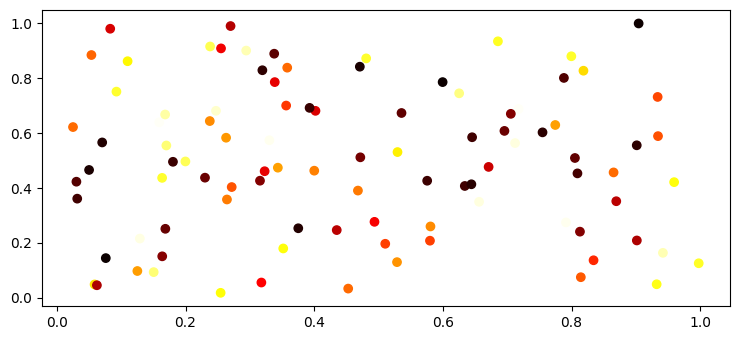

In [24]:
import numpy as np
from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Random data of 100×3 dimension
data = np.array(np.random.random((100, 3)))

# Scatter plot
plt.scatter(data[:, 0], data[:, 1], c=data[:, 2], cmap='hot')

# Display the plot
plt.show()